In [1]:
# Install required libraries
!pip install -q transformers datasets peft accelerate matplotlib scikit-learn opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency re

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
from peft import LoraConfig, get_peft_model
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

2025-08-21 16:10:43.237521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755792643.414852      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755792643.466847      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU available: True
GPU: Tesla P100-PCIE-16GB


In [3]:
import os

# Find the actual dataset structure
dataset_path = '/kaggle/input/imagesoasis'

# Recursively search for image files to understand the structure
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} images total")

# Discover the actual folder structure
folder_structure = {}
for img_path in image_paths[:10]:  # Check first 10 images to understand structure
    relative_path = os.path.relpath(img_path, dataset_path)
    folders = relative_path.split(os.sep)
    print(f"Image path: {relative_path}")
    
    # Track folder structure
    for i, folder in enumerate(folders[:-1]):  # Exclude filename
        if folder not in folder_structure:
            folder_structure[folder] = set()
        folder_structure[folder].add(folders[i+1] if i+1 < len(folders)-1 else "IMAGE")

print("\nFolder structure analysis:")
for folder, contents in folder_structure.items():
    print(f"{folder}: {contents}")

# Let's find where the actual class folders are
class_candidates = []
for root, dirs, files in os.walk(dataset_path):
    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files):
        # This folder contains images directly
        class_name = os.path.basename(root)
        num_images = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        if num_images > 0:
            class_candidates.append((class_name, root, num_images))

print("\nPotential class folders:")
for class_name, path, count in class_candidates:
    print(f"{class_name}: {count} images at {path}")

# Use the discovered class folders
if class_candidates:
    class_names = [name for name, path, count in class_candidates]
    dataset_path = os.path.dirname(class_candidates[0][1])  # Get parent directory
    print(f"\nUsing classes: {class_names}")
    print(f"Dataset path: {dataset_path}")
else:
    # Fallback: look for any folders that might be classes
    print("No class folders found. Listing all directories:")
    all_items = os.listdir(dataset_path)
    for item in all_items:
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path):
            print(f"Directory: {item}")
            # Check if it contains subdirectories that might be classes
            subitems = os.listdir(item_path)
            for subitem in subitems:
                subitem_path = os.path.join(item_path, subitem)
                if os.path.isdir(subitem_path):
                    images = [f for f in os.listdir(subitem_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                    if images:
                        print(f"  -> {subitem}: {len(images)} images")
                        class_names = [subitem]
                        dataset_path = item_path
                        break

class_to_idx = {name: idx for idx, name in enumerate(class_names)}
print(f"Final class mapping: {class_to_idx}")

Found 86437 images total
Image path: Data/Non Demented/OAS1_0302_MR1_mpr-3_154.jpg
Image path: Data/Non Demented/OAS1_0114_MR1_mpr-1_130.jpg
Image path: Data/Non Demented/OAS1_0150_MR1_mpr-3_129.jpg
Image path: Data/Non Demented/OAS1_0253_MR1_mpr-3_113.jpg
Image path: Data/Non Demented/OAS1_0349_MR1_mpr-4_150.jpg
Image path: Data/Non Demented/OAS1_0045_MR1_mpr-2_102.jpg
Image path: Data/Non Demented/OAS1_0209_MR1_mpr-4_128.jpg
Image path: Data/Non Demented/OAS1_0074_MR1_mpr-4_140.jpg
Image path: Data/Non Demented/OAS1_0330_MR1_mpr-4_112.jpg
Image path: Data/Non Demented/OAS1_0234_MR1_mpr-4_113.jpg

Folder structure analysis:
Data: {'Non Demented'}
Non Demented: {'IMAGE'}

Potential class folders:
Non Demented: 67222 images at /kaggle/input/imagesoasis/Data/Non Demented
Very mild Dementia: 13725 images at /kaggle/input/imagesoasis/Data/Very mild Dementia
Moderate Dementia: 488 images at /kaggle/input/imagesoasis/Data/Moderate Dementia
Mild Dementia: 5002 images at /kaggle/input/imagesoa

In [4]:
# Define expected class names based on the dataset
class_names = ['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented']

# Check which classes actually exist
existing_classes = []
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.exists(class_path):
        existing_classes.append(class_name)
        num_images = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"✓ {class_name}: {num_images} images")
    else:
        print(f"✗ {class_name}: Not found")

# Use existing classes
class_names = existing_classes
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
print(f"\nUsing classes: {class_names}")
print("Class mapping:", class_to_idx)

# If no classes found, try to auto-discover
if not class_names:
    print("Auto-discovering classes...")
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path):
            # Check if it contains images
            images = [f for f in os.listdir(item_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if images:
                class_names.append(item)
                print(f"Discovered: {item} ({len(images)} images)")
    
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    print(f"Discovered classes: {class_names}")

✗ MildDemented: Not found
✗ ModerateDemented: Not found
✗ VeryMildDemented: Not found
✗ NonDemented: Not found

Using classes: []
Class mapping: {}
Auto-discovering classes...
Discovered: Non Demented (67222 images)
Discovered: Very mild Dementia (13725 images)
Discovered: Moderate Dementia (488 images)
Discovered: Mild Dementia (5002 images)
Discovered classes: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']


In [5]:
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load images from each class folder
        for class_name in class_names:
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                for img_name in image_files:
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(class_to_idx[class_name])
                
                print(f"Loaded {len(image_files)} images from {class_name}")
            else:
                print(f"Warning: Class folder {class_name} not found!")
        
        if len(self.images) == 0:
            raise ValueError("No images found! Check dataset structure.")
        
        print(f"\nTotal: {len(self.images)} images from {len(class_names)} classes")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return placeholder
            return torch.zeros(3, 224, 224), 0

In [6]:
# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = AlzheimerDataset(dataset_path, transform=train_transform)

# Split dataset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

# Apply test transform to test dataset
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Loaded 67222 images from Non Demented
Loaded 13725 images from Very mild Dementia
Loaded 488 images from Moderate Dementia
Loaded 5002 images from Mild Dementia

Total: 86437 images from 4 classes
Train samples: 69149, Test samples: 17288


In [7]:
# Load pre-trained Swin Transformer
model_name = "microsoft/swin-tiny-patch4-window7-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),  # Dynamic based on number of classes
    ignore_mismatched_sizes=True
)

print(f"Swin Transformer loaded for {len(class_names)} classes!")

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Swin Transformer loaded for 4 classes!


In [8]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],
    lora_dropout=0.1,
    bias="none",
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 317,952 || all params: 27,840,382 || trainable%: 1.1421


In [9]:
# Initialize accelerator
accelerator = Accelerator()

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Prepare with accelerator
model, optimizer, train_loader, test_loader = accelerator.prepare(
    model, optimizer, train_loader, test_loader
)

print("Training setup complete!")

Training setup complete!


In [11]:
# Training loop
model.train()
for epoch in range(5):
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        if batch_idx % 50 == 0:
            batch_acc = (preds == labels).float().mean().item()
            print(f'Epoch {epoch+1}/5 | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f} | Acc: {batch_acc:.4f}')
    
    epoch_acc = correct / total
    print(f'Epoch {epoch+1} completed | Avg Loss: {total_loss/len(train_loader):.4f} | Train Acc: {epoch_acc:.4f}')

print("Training completed!")

Epoch 1/5 | Batch 0/4322 | Loss: 0.0007 | Acc: 1.0000
Epoch 1/5 | Batch 50/4322 | Loss: 0.0010 | Acc: 1.0000
Epoch 1/5 | Batch 100/4322 | Loss: 0.0003 | Acc: 1.0000
Epoch 1/5 | Batch 150/4322 | Loss: 0.0048 | Acc: 1.0000
Epoch 1/5 | Batch 200/4322 | Loss: 0.0011 | Acc: 1.0000
Epoch 1/5 | Batch 250/4322 | Loss: 0.0009 | Acc: 1.0000
Epoch 1/5 | Batch 300/4322 | Loss: 0.0003 | Acc: 1.0000
Epoch 1/5 | Batch 350/4322 | Loss: 0.0010 | Acc: 1.0000
Epoch 1/5 | Batch 400/4322 | Loss: 0.0000 | Acc: 1.0000
Epoch 1/5 | Batch 450/4322 | Loss: 0.0646 | Acc: 0.9375
Epoch 1/5 | Batch 500/4322 | Loss: 0.0847 | Acc: 0.9375
Epoch 1/5 | Batch 550/4322 | Loss: 0.0594 | Acc: 1.0000
Epoch 1/5 | Batch 600/4322 | Loss: 0.0003 | Acc: 1.0000
Epoch 1/5 | Batch 650/4322 | Loss: 0.0015 | Acc: 1.0000
Epoch 1/5 | Batch 700/4322 | Loss: 0.0006 | Acc: 1.0000
Epoch 1/5 | Batch 750/4322 | Loss: 0.0002 | Acc: 1.0000
Epoch 1/5 | Batch 800/4322 | Loss: 0.0002 | Acc: 1.0000
Epoch 1/5 | Batch 850/4322 | Loss: 0.0216 | Acc: 1.

In [12]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(accelerator.gather(preds).cpu().numpy())
        all_labels.extend(accelerator.gather(labels).cpu().numpy())

print("Evaluation completed!")

Evaluation completed!


Accuracy: 0.9990
F1 Score: 0.9990
Recall: 0.9990
Precision: 0.9990

Classification Report:
                    precision    recall  f1-score   support

      Non Demented       1.00      1.00      1.00     13449
Very mild Dementia       1.00      1.00      1.00      2761
 Moderate Dementia       1.00      0.98      0.99        96
     Mild Dementia       0.99      1.00      1.00       982

          accuracy                           1.00     17288
         macro avg       1.00      0.99      1.00     17288
      weighted avg       1.00      1.00      1.00     17288



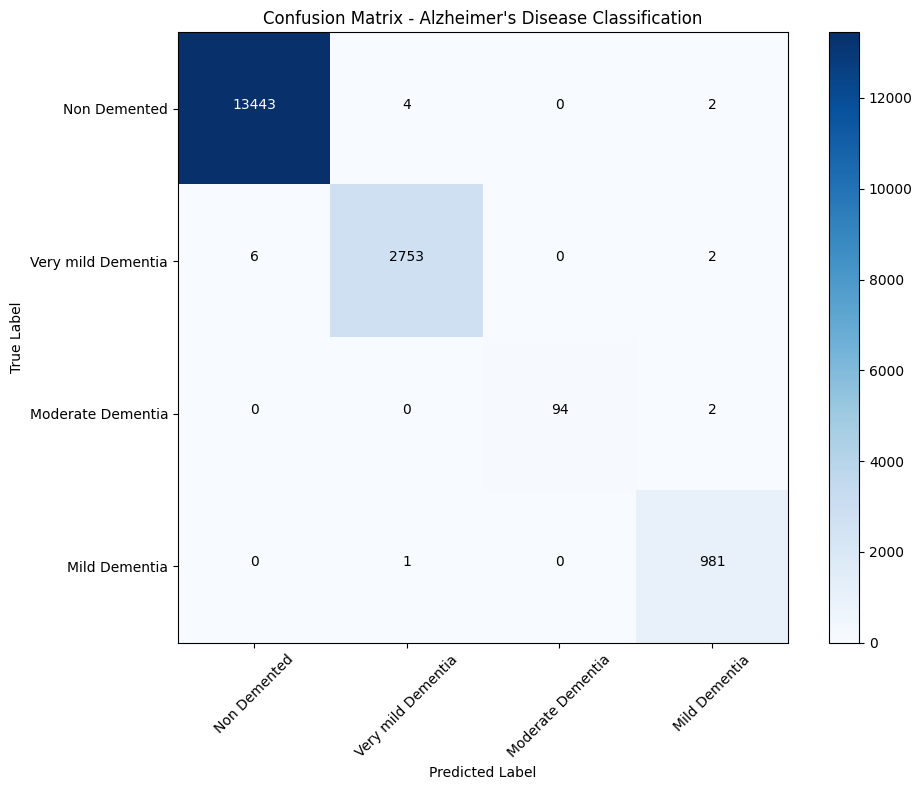

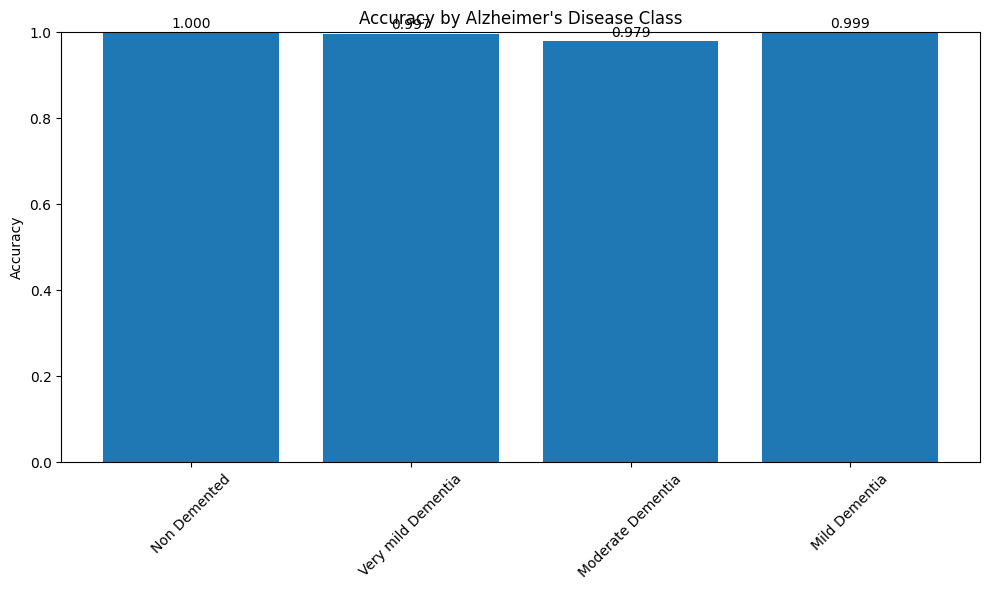

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,recall_score, precision_score
# Calculate performance metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Alzheimer\'s Disease Classification')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), 
                horizontalalignment="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()

# Plot accuracy by class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies)
plt.title('Accuracy by Alzheimer\'s Disease Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i, v in enumerate(class_accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()